# PT Gradient

An example of how to compute the derivative of an objective function $Z=Z(\rho_f)$ of the final state with respect to a set of system parameters or 'controls' using the OQuPy package.
* add binder link
* add jupyter link
* read through the text below and code along

The following packages are required

In [5]:
import numpy as np
import oqupy
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size' : 14.0, 'lines.linewidth':2.50, 'figure.figsize':(8,6)})

The OQuPy version should be `>=v0.5.0`

In [6]:
oqupy.__version__

'0.4.0'

# Introduction

The goal of this tutorial is to calculate the derivative of some generic objective function $Z(\rho_f)$ which only depends on the value of the final density matrix $\rho_f$. This can be decomposed via the chain rule by noting that the final state depends on the set of $N_t$, $(d_H^2,d_H^2)$-dimensional propagators $\{U_n(t) \}_{i=0,..,N_t-1}$ and each propagator depends on the set of $N$ control parameters at that time $\{c_a (t)\}_{i=0,..,N-1}$. Then, the derivative of the objective function with respect to the control parameter $c_a$ at the $n^\text{th}$ timestep is

$$
\frac{\partial Z}{\partial c_a^n}=\sum_n\sum_{i,j,k}^{d_{H_S}^2}
\frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}
\frac{\partial U^{jk}_n}{\partial c_a^n}.
$$
This expression is depicted diagramatically in Fig S2 of the supplement. The three terms in the product are understood as follows:
1. $\frac{\partial Z}{\partial \rho_f^i}$ : The derivative of the objective function with respect to the final state. This is computed analytically and corresponds to rank-1 tensor in Liouville space.
2. $\frac{\partial\rho_f^i}{\partial U^{jk}_n}$ : The derivative of the final state with respect to the propagator at the $n^{\text{th}}$ time-step. Due to the linearity of our network, this is the same as the diagram for the time-evolution of the initial state after $N_t$ steps with the propagator(s) at the $n^{\text{th}}$ timestep removed. The rank of this tensor depends on the order of the Trotterization of the propagators. PT-TEMPO implements a second-order splitting, such that the tensors are rank-$4$.
3. $\frac{\partial U^{jk}_n}{\partial c_a}$ : The derivative of a propagator at the $n^{\text{th}}$ timestep with respect to control parameter $a$ at the $n^\text{th}$ timestep. Due to the second Trotterization, there are $2 N_t$ half-propagators and therefore $2 N_t$ half-propagator derivatives. These are computed via finite-difference and are of rank-$2$. 

Expression 2. is not calculated directly. Rather, we perform a forward propagation of the initial state $\rho_0$ and back propagation of the target derivative $\frac{\partial Z}{\partial \rho_f^i}$ for $n$ time-steps. The stored tensors are of rank-$2$ with an external 'system' leg which connects to the propagators and an internal 'bond' leg connecting to the PT-MPOs. By joining the bond legs of the appropriate tensors from the forward and back propagations we obtain the rank-$4$ tensor $ \frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}$ which, when contracted with the propagator derivatives $\frac{\partial U^{jk}_n}{\partial c_a}$, gives $\frac{\partial Z}{\partial c_a^n}$.

As an example, we model a spin-boson system coupled to an external field and compute the gradient with respect to each parameter.

# Example - Spin Boson Model

### 1. System Definition

We choose the system modelled in [Butler2023] (https://arxiv.org/abs/2303.16002), a spin-boson model representing a quantum-dot driven by a laser pulse. We consider a time-dependent system Hamiltonian 
$$
H_S = h_x(t) \sigma_x + h_z(t) \sigma_z ,
$$
where the parameters $h_i(t)$, $i=x,z$ represent a set of fields controlling the system dynamics. A system of this type is represented by a `ParameterizedSystem` object. This object requires a Callable which returns the Hamiltonian at a given timestep. It encapsulates the system dynamics via calculation of the propagators $U^{ij}$ and propagator derivatives $\frac{\partial U^{ij}_n}{\partial c_a^n}$ using the functions `get_propagators` and `get_propagator_derivatives` respectively.

In [7]:
# function which returns system Hamiltonian for a given timestep given the parameters at that step
def discrete_hamiltonian(hx,hz):
    return hx*oqupy.operators.sigma('x') + hz*oqupy.operators.sigma('z')

# definition of parameterized system
system = oqupy.ParameterizedSystem(discrete_hamiltonian)

We then provide a $(2*N_t,N)$-dimensional tuple of parameters which define the value of the fields at each half time-step. For simplicity, we choose a pair of constant fields $h_x=0$ and $h_z=\pi/T$. We choose a pulse duration $T=5 \text{ps}^{-1}$ and model over $100$ timesteps. We work in Planck units throughout ($\hbar = k_B = 1$) and take $\text{ps}^{-1}$ as units of angular momentum.

In [8]:
max_time= 5
num_steps = 100
h_z = np.ones(2*num_steps) * np.pi / max_time
h_z = h_z.tolist()
h_x = np.zeros(2*num_steps).tolist()

parameters = list(zip(h_x,h_z))

### 2. Process Tensor generation

The bath and interaction Hamiltonians are 
$$
H_B = \sum_k \omega_k b_k^\dag b_k 
$$
and 
$$
H_{SB} = \frac{1}{2} \sigma_z \sum_k (g_k b_k^\dag + g^*_k b_k),
$$
respectively. The bath interaction terms $g_k$ and $\omega_k$ are characterised by the super-ohmic spectral density
$$
J(\omega)  = 2 \alpha \omega^3 \omega_c^{-2} \text{exp}(- \frac{\omega^2}{\omega^2_c}).
$$
with $\omega_c=3.04 \text{p s}^{-1}$ and $\alpha=0.126$.
We take the bath to be at $T=5 \text{K}$. The process tensor is then generated as follows.

In [9]:
# spectral density parameters
alpha = 0.126
omega_cutoff = 3.04
temperature = 5 * 0.1309 # 1K = 0.1309/ps in natural units

# numerical tempo parameters
dt = 0.05
dkmax = 60
esprel = 10**(-7)
max_time = 5

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)

tempo_params = oqupy.TempoParameters(dt=dt, dkmax=dkmax, epsrel=esprel)

In [10]:
# process tensor creation
process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=0,
                                        end_time=max_time,
                                        parameters=tempo_params
                                        )

--> PT-TEMPO computation:
100.0%  100 of  100 [########################################] 00:00:09
Elapsed time: 10.0s


### 3. Objective Function: The Fidelity

For our objective function, we choose the fidelity $\mathcal{F(\rho_t,\rho_f)}$ between a target state $\rho_t$ and the final state $\rho_f$. For simplicity, we consider a pure target state $\rho_t = \ket{\sigma}\bra{\sigma}$ such that $\mathcal{F}=\bra{\sigma} \rho_f \ket{\sigma}$. In Liouville space, this is expressed as $\mathcal{F} = \langle \langle \rho_t^T | \rho_f \rangle \rangle = \sum_i^{d_H^2} \rho^T_{t,i} \rho_{f,i}$, where $| \cdot  \rangle \rangle$ denotes a vectorized density matrix and $d_H$ the Hilbert space dimension. The derivative with respect to the final state is then 
$$
\frac{\partial \mathcal{F}}{\partial \rho_f} = \rho_t^T.
$$
We model the state transfer between an initial state $\rho_i=\ket{x+} \bra{x+}$ and target state $\rho_t=\ket{x-} \bra{x-}$.

Note: Often the quantity called the fidelity is the square of what we have defined here. The physical interpretation is the same for both definitions.

In [12]:
initial_state = oqupy.operators.spin_dm('x+')
target_derivative = oqupy.operators.spin_dm('x-').T

### 4. Adjoint Method

Now that we have defined our objective function, environment and system, we are able to perform back propagation in order to compute the gradient and dynamics. This is done via `state_gradient`. The function computes $\{\rho(t_n) \}_{n=0,..,N-1}$ and $\{ \frac{\partial Z}{\partial \rho_f^i}\frac{\partial\rho_f^i}{\partial U^{jk}_n} \}_{n=0,...,2N_t-1}$ using a forward and back propagation of $\rho_0$ and $ \frac{\partial Z}{\partial \rho_f}$ as outlined in the introduction. It then calculates the propagators and propagator derivatives $\frac{\partial U^{ij}_n}{\partial c_a^n}$ using the parameters and `ParameterizedSystem` object. These are then combined as in the chain rule to get the derivative of the objective function with respect to each parameter at each timestep $\{ ( \frac{\partial Z}{\partial c_j (t_i)} )_{j=0,...,N-1} \}_{i=0,...,2N_t-1}$. The dictionary returned contains:
* `gradient` : the list of gradients $\{ ( \frac{\partial Z}{\partial c_j (t_i)} )_{j=0,...,N-1} \}_{i=0,...,2N_t-1}$ at each half time-step
* `gradprop` : the list of tensors $\{ \frac{\partial Z}{\partial \rho_f^i}\frac{\partial\rho_f^i}{\partial U^{jk}_n} \}_{n=0,...,N-1}$ 
* `dynamics` : the states and times
* `final state` : the final state 

In [13]:
# forward-backpropagation + combination of derivatives
gradient_dynamics = oqupy.state_gradient(
                system=system,
                initial_state=initial_state,
                target_derivative=target_derivative,
                process_tensors=[process_tensor],
                parameters=parameters)

gradients= gradient_dynamics['gradient'] # gradient at each half time-step

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:01
Elapsed time: 1.1s


In order to get the gradient with respect to the full time-steps, we just sum the adjacent elements.

In [14]:
for i in range(0,gradients.shape[0],2): 
        gradients[i,:]=gradients[i,:]+gradients[i+1,:]
gradients=gradients[0::2]

Plotting our results against the timesteps:

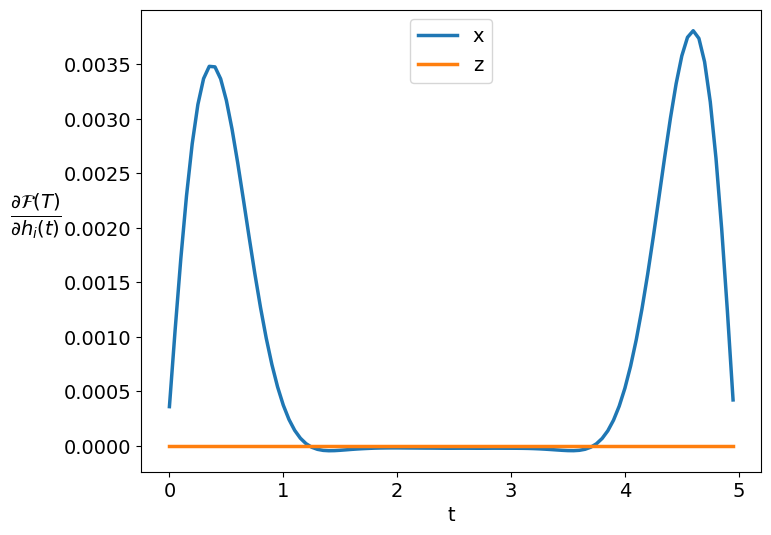

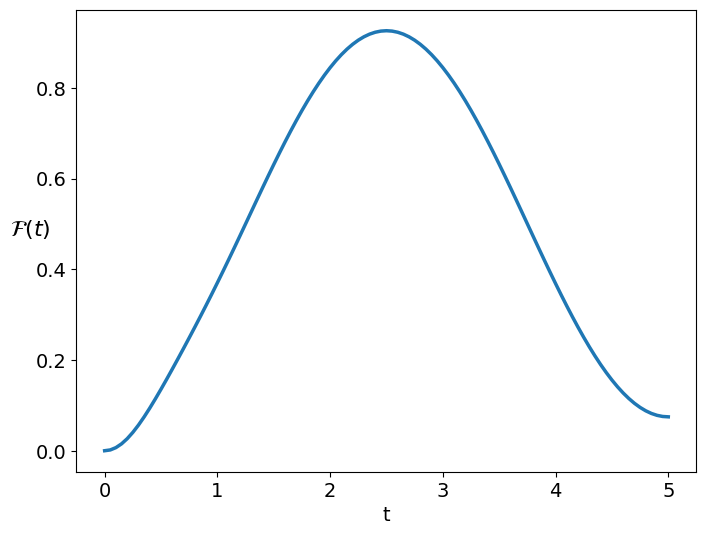

In [21]:
from oqupy.helpers import get_full_timesteps

times_fidelity = get_full_timesteps(process_tensor,start_time=0,inc_endtime=True)
times_gradient = get_full_timesteps(process_tensor,start_time=0,inc_endtime=False)

x_derivs , z_derivs = zip(*gradients.real)
plt.figure()

plt.plot(times_gradient,x_derivs,label='x')
plt.plot(times_gradient,z_derivs,label='z')

plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F}(T)}{\partial h_i (t)}$",rotation=0,fontsize=20,labelpad=20)
plt.xlabel("t")
plt.show()

plt.figure()

hs_dim = 2

target_ndarray = target_derivative.T
target_ndarray = target_ndarray.reshape(hs_dim**2)

dynamics = gradient_dynamics['dynamics'] 
fidelitys=[]

for state in dynamics.states:
    v_state = state.reshape(hs_dim**2)
    fidelity=target_ndarray@v_state
    fidelitys.append(fidelity.real)

plt.plot(times_fidelity,fidelitys)
plt.ylabel(r"$\mathcal{F} (t)$",rotation=0,fontsize=16)
plt.xlabel("t")
plt.show()